# Appendix

Things that don't go in the main notebook but are important to show how we got there.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import data as d
from get_sm_for_sim import get_sm_for_sim, get_smf
import smhm_fit



%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A: Initial coords for Vmax@Mpeak

Per conversation with Peter, we should be getting stellar mass not from halo mass (or Mpeak) but rather from Vmax@Mpeak. I think this is because halo mass starts to become stripped much earlier than circular velocity reduces. Therefore when getting stellar masses from Vmax, halos that are close to each other will have higher (an more accurate) masses than if we got using their mass.

In [3]:
sim_data, sim_size = d.load_mdpl()

In [21]:
# Starting params from https://redwoodforest.slack.com/files/U5WT8PBKN/FDD17SXN0/image.png 
# params = [10**12.52, 10**10.91, 0.45, 0.6, 1.83] # m1, sm0, beta, delta, gamma
mass_b_params = [12.52, 10.91, 0.45, 0.6, 1.83]
mass_s_params = [-0.06, 1.08]
mass_x_field = "halo_mvir"
# best_fit = [12.46178498, 10.87987102,  0.45690214,  0.636816,    1.87057079, -0.0614553,   1.07878507]

# sm0 and beta shouldn't change
# m1 we just set to be roughly the vmax equivalent
# the delta and gamma slopes we iterated on (i.e. change them, run next cell) until finding a decent start
vmax_b_params = [2.4, 10.91, 0.45, 0.3, 0.2]
# These are pretty easy to get just by looking at the plots (should be ~0.3 at the lowest vmax and ~0.15 at the highest)
vmax_s_params = [-0.1, 0.5]
vmax_x_field = "Vmax@Mpeak"

This looks reasonable


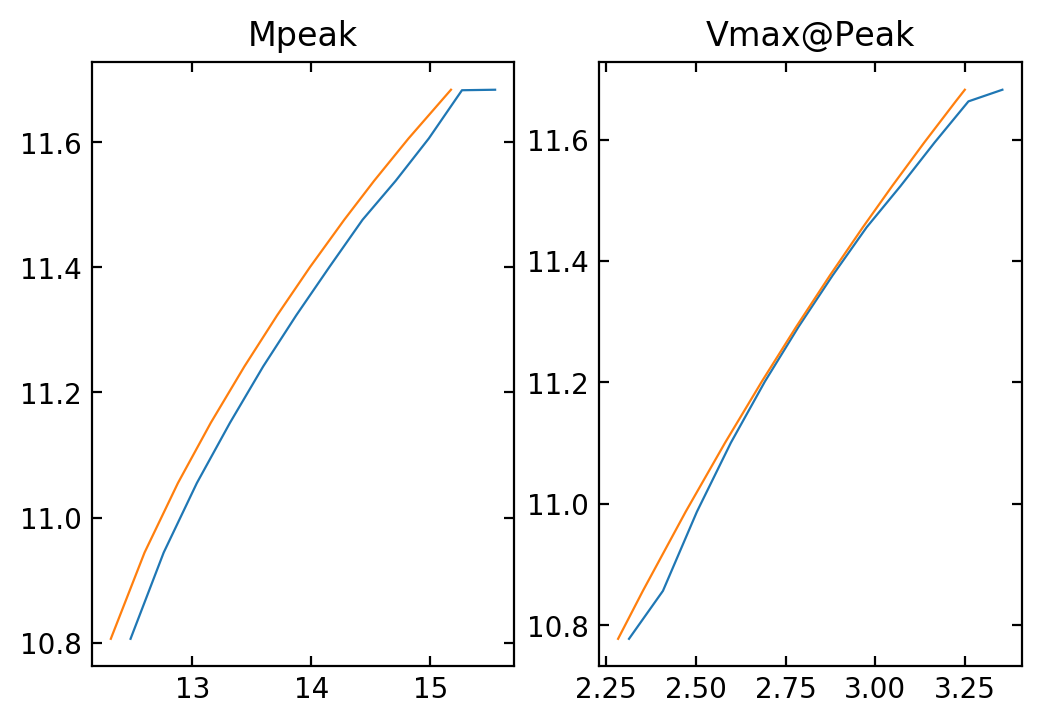

In [23]:
log_stellar_masses = get_sm_for_sim(sim_data, mass_b_params, mass_s_params, mass_x_field)

_, axes = plt.subplots(1, 2)

for i, (x_value, params, title) in enumerate([
    (mass_x_field, mass_b_params, "Mpeak"),
    (vmax_x_field, vmax_b_params, "Vmax@Peak"),
]):
    sample_sm, bin_edges, _ = scipy.stats.binned_statistic(np.log10(sim_data[x_value]), log_stellar_masses, bins = 12)
    sample_x = bin_edges[:-1] + np.diff(bin_edges)[0]

    axes[i].plot(sample_x, sample_sm, label="data")
    
    model_x = smhm_fit.f_shmr_inverse(sample_sm, 10**params[0], 10**params[1], *params[2:])
    axes[i].plot(model_x, sample_sm, label="model")
    
    axes[i].set(title=title)

print("This looks reasonable")

# B: Sanity check we are converting masses to /h correctly

17.415844702499612 15.625


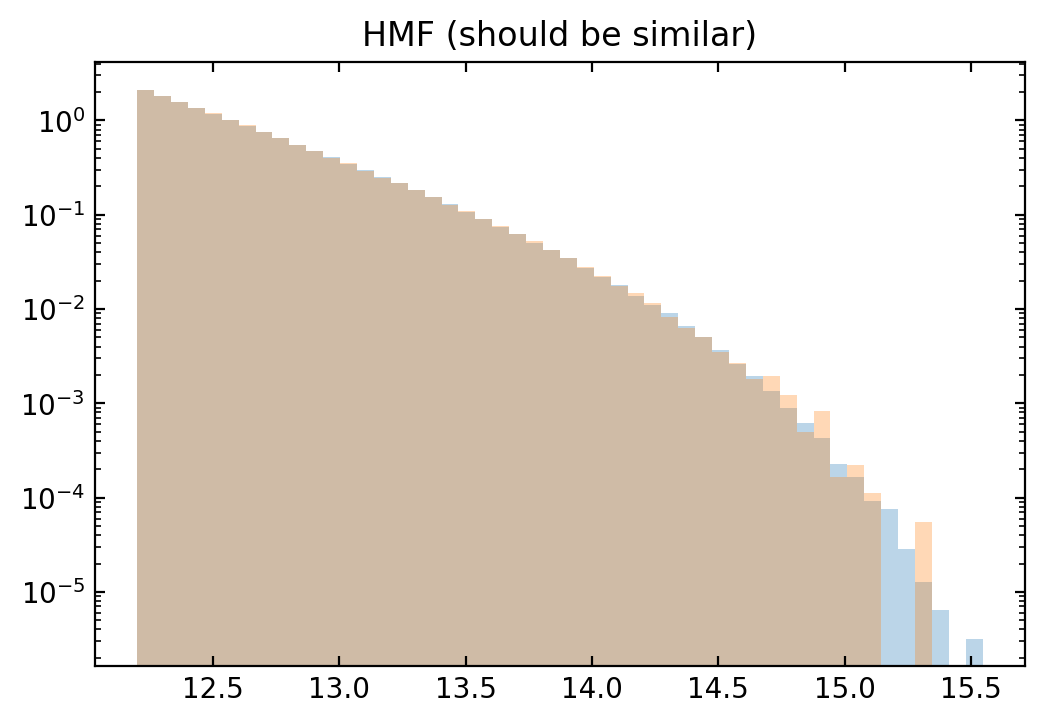

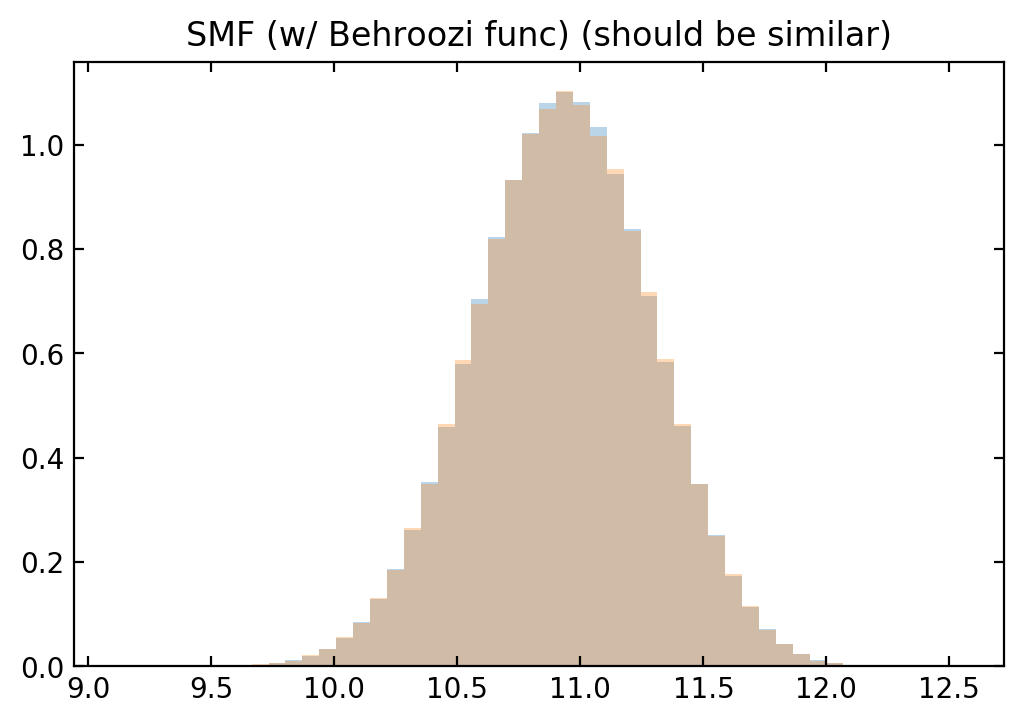

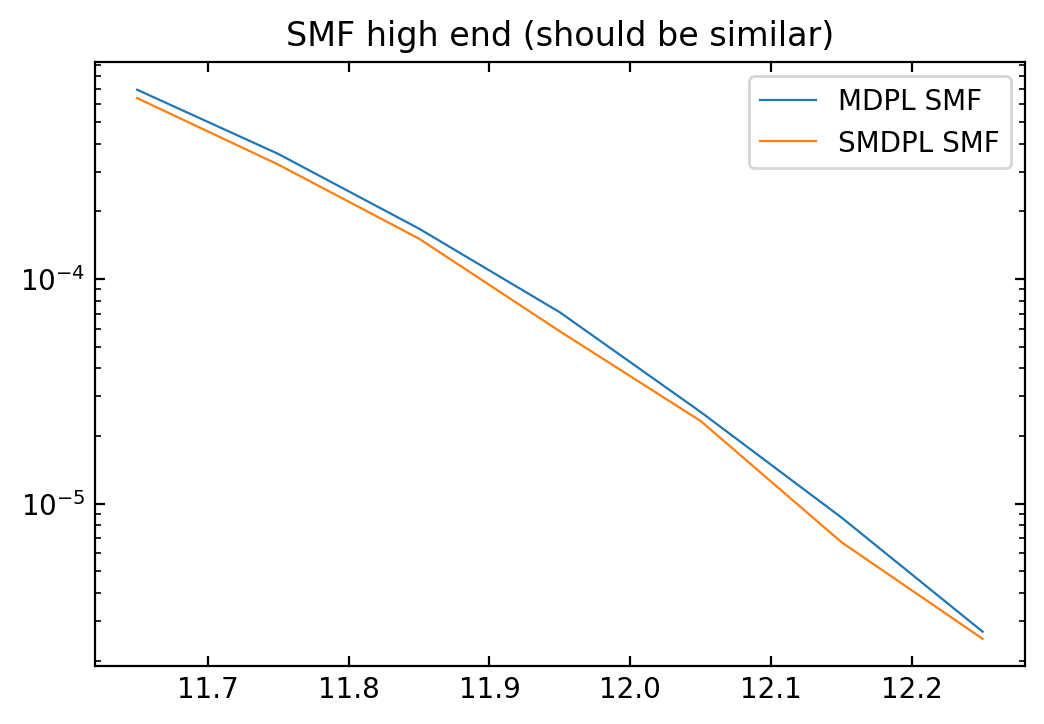

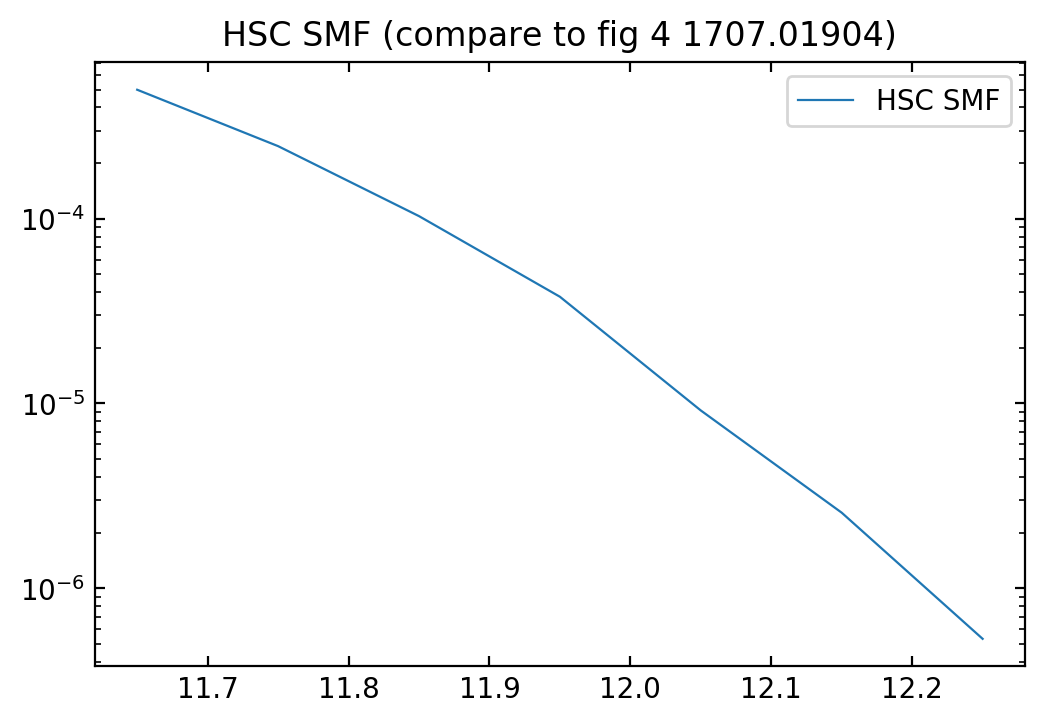

In [33]:
mdpl, mdpl_size = d.load_mdpl()
smdpl, smdpl_size = d.load_smdpl()
obs_smf = d.load_smf()

# Halo masses should be similar in smdpl and mdpl
_, ax = plt.subplots()
_, bins, _ = ax.hist(np.log10(mdpl["halo_mvir"]), bins=50, density=True, alpha=0.3)
ax.hist(np.log10(smdpl["halo_mvir"]), bins=bins, density=True, alpha=0.3)
ax.set(yscale="log", title="HMF (should be similar)")

# Stellar masses should be similar
mass_b_params = [12.52, 10.91, 0.45, 0.6, 1.83]
mass_s_params = [-0.06, 1.08]
mass_x_field = "halo_mvir"
mdpl_sm = get_sm_for_sim(mdpl, mass_b_params, mass_s_params, mass_x_field)
smdpl_sm = get_sm_for_sim(smdpl, mass_b_params, mass_s_params, mass_x_field)

_, ax = plt.subplots()
_, bins, _ = ax.hist(mdpl_sm, bins=50, density=True, alpha=0.3)
ax.hist(smdpl_sm, bins=bins, density=True, alpha=0.3)
ax.set(title="SMF (w/ Behroozi func) (should be similar)")

# The SMF should be similar
sm_bins = np.linspace(11.6, 12.3, 8)
sm_bin_centers = (sm_bins[:-1] + sm_bins[1:]) / 2

_, ax = plt.subplots()
ax.plot(sm_bin_centers, get_smf(mdpl_sm, sm_bins, mdpl_size**3), label = "MDPL SMF")
ax.plot(sm_bin_centers, get_smf(smdpl_sm, sm_bins, smdpl_size**3), label="SMDPL SMF")
ax.set(yscale="log", title="SMF high end (should be similar)")
ax.legend()

# The ratio of the number of galaxies should be similar to the ratio of volumes
print(len(mdpl) / len(smdpl), mdpl_size**3 / smdpl_size**3)

# Smf should be quite a bit larger than 1e-4 at 11.6 (different to fig 4 https://arxiv.org/pdf/1707.01904.pdf)
_, ax = plt.subplots()
plt.plot(obs_smf["logm_mean"], obs_smf["smf"], label="HSC SMF")
ax.set(yscale="log", title="HSC SMF (compare to fig 4 1707.01904)")
ax.legend()